# Dataset Caso de uso Mexico

In [2]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import chardet
import multiprocessing
import random
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset

## Read dataset

Let's read the dataset to use.

In [0]:
def find_encoding(fname):
    r_file = open(fname, 'rb').read()
    result = chardet.detect(r_file)
    charenc = result['encoding']
    return charenc


my_encoding = find_encoding('/content/200502COVID19MEXICO.csv')

In [0]:
df = pd.read_csv('/content/200502COVID19MEXICO.csv', encoding=my_encoding)

In [5]:
my_encoding

'ISO-8859-1'

## Data cleaning

In [6]:
df.shape

(93791, 35)

The dataset consists of:

- 93791 **rows** or instances
- 35 **columns** or variables.

Let's see their contents.

In [7]:
df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-05-02,0ceb0f,1,4,1,1,1,1,1,1,2020-01-14,2020-01-14,9999-99-99,97,2,28,1,2,2,2,2,2,2,2,2,2,2,2,2,99,1,99,MÃ©xico,99,97
1,2020-05-02,1d9580,1,12,2,2,15,2,2,1,2020-04-19,2020-04-17,9999-99-99,97,2,23,1,97,2,2,2,2,2,2,2,2,2,2,2,1,1,99,MÃ©xico,99,97
2,2020-05-02,119b76,1,4,21,2,21,21,114,1,2020-03-23,2020-03-23,9999-99-99,97,2,49,1,97,2,1,2,2,2,1,2,2,2,2,2,99,1,99,MÃ©xico,99,97
3,2020-05-02,0e6c05,1,4,2,2,2,2,2,2,2020-03-24,2020-03-16,9999-99-99,2,1,28,1,97,2,2,2,2,2,2,2,2,1,2,2,99,1,99,MÃ©xico,99,2
4,2020-05-02,140d7f,1,12,29,1,29,29,21,1,2020-03-28,2020-03-23,9999-99-99,97,2,31,1,2,99,2,2,2,2,2,2,2,2,2,2,2,2,99,MÃ©xico,99,97


In [0]:
df_1=df.drop(['FECHA_ACTUALIZACION','ID_REGISTRO','FECHA_INGRESO','FECHA_SINTOMAS','FECHA_DEF','PAIS_NACIONALIDAD','PAIS_ORIGEN'],axis=1)

In [0]:
df_1=df_1.astype(int)

In [0]:
fig, ax = plt.subplots(figsize=(15,10))      

sns.heatmap(df_1, center=0, cmap='Blues_r', annot=True, fmt='.3f',ax=ax)

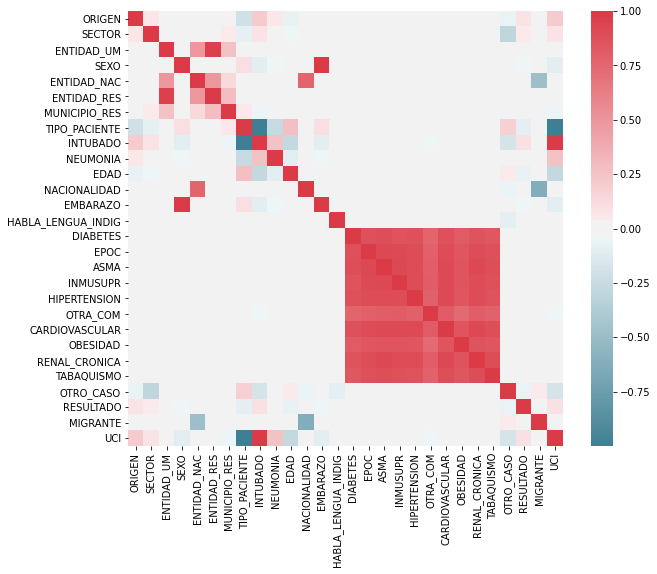

In [15]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df_1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

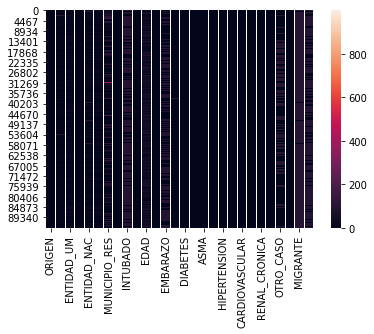

In [12]:
hmap=sns.heatmap(df_1)
hmap.figure.savefig("Correlation_Heatmap_with_Seaborn.png",
                    format='png',
                    dpi=1500)

In [0]:
df.columns

FECHA_ACTUALIZACION

ID_REGISTRO = ID_USER (TEXTO)

ENTIDAD_RES = CCAA -> RIESGO_DE_ZONA (01-32,36,97-does not apply,98-is ignored,99-not specified)

FECHA_SINTOMAS = beginning of symptoms (date recorded by app) there is not 9999-99-99

EDAD = NUMERIC

ENFERMEDADES = INTUBADO, NEUMONIA, DIABETES, EPOC, ASMA, INMUSUPR, HIPERTENSION, CARDIOVASCULAR, OBESIDAD, RENAL_CRONICA, OTRA_COM(other deseases)
-> YES(1), NO(2), NOT APPLIES(97), IGNORED(98), UNSPECIFIED(99)

FECHA_DEF = AAAA-MM-DD (9999-99-99-> Not dead=90.492)

TABAQUISMO = SMOKER: SI(1), NO(2), DOES NOT APPLY(97), IS IGNORED(98), UNSPECIFIED(99)

OTRO_CASO = DIRECT CONTACT: YES(1), NO(2), DOES NOT APPLY(97), IS IGNORED(98), UNSPECIFIED(99)

RESULTADO = POSITIVE(1), NEGATIVE(2), PENDENT(3)

UCI = TARGET SEVERE SEVERITY: YES(1), NO(2), DOES NOT APPLY(97), IS IGNORED(98), UNSPECIFIED(99)

STEPS
1. Remove the columns we don't need
2. Check that the id_registry's are unique
3. Rename columns
4. Decode the options for each variable
5. Replace "Not applicable"/"Ignored"/"Not specified"/9999-99-99 with NaNs
6. The target column is categorical(uci=!1:mild, uci=1:severe,date_def=!NaN: very severe)-> Group and transform ICU and DEF_DATE columns
7. Make OHE-dummies if required to have only ones and zeros
8. Define predictive model
9. Creating and applying an ML model


We check that the update date is the current or most recent, to ensure that the data we are processing is the latest real data, which will allow us to make the algorithm as accurate/precise as possible.

In [0]:
df.FECHA_ACTUALIZACION.unique()

### 1. Remove the columns we don't need

In [0]:
list_to_drop=['FECHA_ACTUALIZACION', 'ORIGEN','SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'NACIONALIDAD', 'HABLA_LENGUA_INDIG', 
       'RESULTADO', 'MIGRANTE', 'PAIS_NACIONALIDAD',
       'PAIS_ORIGEN']

In [0]:
df=df.drop(columns=list_to_drop)
df

### 2. Check that the id_registration's are unique

In [0]:
df.ID_REGISTRO.nunique()

There are 93,791 unique records that match the number of rows, so we validate that there are no duplicates in the report.

### 3. Rename columns

We rename the columns so as not to confuse terms and to equate the names to the terminology applied in the previous codes.

In [0]:
df.columns

In [0]:
df=df.rename(columns={'ID_REGISTRO':'USER_ID', 'ENTIDAD_RES':'REGION', 'FECHA_SINTOMAS':'SYMPTOMS_DATE', 'FECHA_DEF':'DEAD', 'INTUBADO':'INTUBATED',
       'NEUMONIA':'PNEUMONIA', 'EDAD':'AGE', 'EMBARAZO':'PREGNANT', 'DIABETES':'DIABETES', 'EPOC':'EPOC', 'ASMA':'ASTHMA', 'INMUSUPR':'IMMUNOSUPPRESSION',
       'HIPERTENSION':'HYPERTENSION', 'OTRA_COM':'OTHERS_DISEASES', 'CARDIOVASCULAR':'CARDIOVASCULAR', 'OBESIDAD':'OBESITY',
       'RENAL_CRONICA':'CHRONIC_RENAL_FAILURE', 'TABAQUISMO':'SMOKER', 'UCI':'ICU'})
df

### 4. Replace the values "No aplica"/"Se ignora"/"No especificado"/9999-99-99 to NaNs

In order to implement the Regex function to replace several strings with NaN, we first have to convert all integer variables to objects. To do this, we look at which variables are objects and which integers.

In [0]:
df.dtypes

The REGION and AGE columns are stored in independent series so that they can be retrieved and added to the dataframe at any time, thus avoiding unnecessary conversion of variables to objects.

In [0]:
df_REGION=df['REGION']
df_AGE=df['AGE']
df=df.drop(columns='AGE')

In [0]:
df

We transform the remaining variables into objects.

In [0]:
df = df.applymap(str)
df

It is checked that all the variables have been transformed into objects.

In [0]:
df.dtypes

The values defined as "no aplica", "se ignora", "no especificado" are replaced by NaNs.

In [0]:
df=df.replace({'9999-99-99|97|98|99': 'NaN'}, regex=True)
df

### 5. Decode the options for each variable.

ID_REGISTRO = ID_USER (TEXTO)

ENTIDAD_RES = CCAA -> RIESGO_DE_ZONA (01-32,36,97-no aplica,98-se ignora,99-no especificado)

FECHA_SINTOMAS = inicio de los síntomas (fecha registrada por la app)no hay 9999-99-99

EDAD = NUMÉRICA

ENFERMEDADES = INTUBADO, NEUMONIA, DIABETES, EPOC, ASMA, INMUSUPR, HIPERTENSION, CARDIOVASCULAR, OBESIDAD, RENAL_CRONICA, OTRA_COM(otras enfermedades)
-> SI(1), NO(2), NO APLICA(97), SE IGNORA(98), NO ESPECIFICADO(99)

FECHA_DEF = AAAA-MM-DD (9999-99-99-> No ha  fallecido=90.492)

TABAQUISMO = FUMADOR: SI(1), NO(2), NO APLICA(97), SE IGNORA(98), NO ESPECIFICADO(99)

OTRO_CASO = CONTACTO DIRECTO: SI(1), NO(2), NO APLICA(97), SE IGNORA(98), NO ESPECIFICADO(99)

RESULTADO = POSITIVO(1), NEGATIVO(2), PENDIENTE (3)

UCI = TARGET GRAVEDAD GRAVE: SI(1), NO(2), NO APLICA(97), SE IGNORA(98), NO ESPECIFICADO(99)

*EMBARAZO?¿?*
*OTRAS ENFERMEDADES¿?¿*

The variable REGION is eliminated because it contains numerical values that we do not want to transform since it is an identifier.

In [0]:
df=df.drop(columns={'REGION','USER_ID','SYMPTOMS_DATE'})
df

All those results that do not meet a condition are shown as a negative dummy(0). Therefore, the values "9999-99-99" are transformed into the deceased category, and "2" into the other categories.

In [0]:
df['DEAD']=df['DEAD'].replace({'NaN':'0'}, regex=True)

In [0]:
df=df.replace({'2':'0'}, regex=True)
df

We regroup the generic dataframe in the EDAD column.

In [0]:
df1=pd.concat([df,df_AGE],axis=1)
df1

It is checked that the EDAD variable does not contain NaNs or inconsistencies.

In [0]:
df1.AGE.unique()

The death dates are converted into a positive dummy(1), replacing all those strings that have date format(xxxx-xx-xx) by another string(1).

In [0]:
df1=df1.replace({'DEAD': r'^....-..-..$'}, {'DEAD': '1'}, regex=True)

We check that we only have the two values we need (0 and 1).

In [0]:
df1.DEAD.unique()

In [0]:
df1

### 6. Grouping ages in ranges

In [0]:
df1['AGE']=pd.cut(df1['AGE'], bins=[0,10,20,30,40,50,60,70,80,90, np.inf])

In [0]:
df1

Dummies of the age variable are made to have the ranges in columns, but before we semaparted the variable of the datset to facilitate its treatment.

In [0]:
df_AGE=pd.DataFrame(df1['AGE'])
df_AGE

In [0]:
dummies = pd.get_dummies(df_AGE)
df_AGE = dummies
df_AGE.head()

We renamed the variables to have the same terminology as the other scripts.

In [0]:
df_AGE=df_AGE.rename(columns={'AGE_(0.0, 10.0]':'AGE_0-9', 'AGE_(10.0, 20.0]':'AGE_10-19', 'AGE_(20.0, 30.0]':'AGE_20-29', 'AGE_(30.0, 40.0]':'AGE_30-39',
       'AGE_(40.0, 50.0]':'AGE_40-49', 'AGE_(50.0, 60.0]':'AGE_50-59', 'AGE_(60.0, 70.0]':'AGE_60-69', 'AGE_(70.0, 80.0]':'AGE_70-79', 'AGE_(80.0, 90.0]':'AGE_80-89', 'AGE_(90.0, inf]':'AGE_>90'})

We unified the old dummies with the general DataFrame.

In [0]:
df2=pd.concat([df1,df_AGE],axis=1)

The AGE column is removed so as not to have the data repeated.

In [0]:
df2=df2.drop(columns='AGE')
df2

### 7. The target column is categorical(uci=!1:leve, uci=1:grave,fecha_def=!NaN: muy grave)-> Group and transform UCI and FECHA_DEF columns.

In [0]:
df2

The function for classifying a patient's condition (mild, severe and very severe) from UCI and DEFUNCIÓN data is defined.

In [0]:
def gravity (a,b): 

    # If you have a date of death, the virus is considered to have affected you very seriously
    if (b == '1'):         
      x = 'muy grave'

    else:

     # If you enter the UCI, it is considered serious
      if (a == '1'):

        x = 'grave' 
     
     # If you do not enter the UCI, it is considered minor
      else:
        x= 'leve'
               
    return (x)

def gravity_state(): 
      
    df2['State'] = df2.apply(lambda row : gravity(row['ICU'],row['DEAD']), axis = 1) 
   
    return df2

In [0]:
df3 = gravity_state()
df3

In [0]:
df3['State'].value_counts()

In [0]:
df3.nunique()